In [1]:
%load_ext autoreload
%autoreload 2

import sklearn.metrics as metrics
from utils.temperature_scaling import ModelWithTemperature
from matplotlib import pyplot as plt
import utils.visualisations
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms

import utils.metrics
import utils.model

import models.resnet_dropout
import models.resnet
import models.unet_model

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("cpu")
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
import os
import numpy as np
from PIL import Image, ImageOps
import cv2

class BBBC010Dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None):
        image_folder = os.path.join(root_dir,"BBBC010_v2_images")
        gt_folder = os.path.join(root_dir,"BBBC010_v1_foreground")
        self.codes = [name.split("_")[0] for name in os.listdir(gt_folder)]
        self.image_names = [os.path.join(image_folder, name) for name in os.listdir(image_folder)]
        self.gt_names = [os.path.join(gt_folder, name) for name in os.listdir(gt_folder)]
        self.transform = transform
        self.target_transform = target_transform



    def __len__(self):
        return len(self.codes)

    def __getitem__(self, idx):
        code = self.codes[idx]
        img1 = list(filter(lambda name: code+"_w1" in name, self.image_names))[0]
        img2 = list(filter(lambda name: code+"_w2" in name, self.image_names))[0]
        gt = list(filter(lambda name: code in name, self.gt_names))[0]

        img1 = cv2.imread(img1, 0)
        img2 = cv2.imread(img2, 0)
        gt = cv2.imread(gt, 0)

        img = np.zeros((2, *img1.shape))

        img[0] = img1 / img1.max()
        img[1] = img2 / img2.max()
        gt = gt / 255
        gt[gt<0.5]=0
        gt[gt>=0.5]=1
        
        img = torch.as_tensor(img, dtype=torch.float)
        gt = torch.as_tensor(gt, dtype=torch.uint8).unsqueeze(0)
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            gt= self.target_transform(gt)

        return img,gt.squeeze(0) 
        



a = BBBC010Dataset("BBBC010")
a[0][0].max(), a[0][0].mean(), a[0][0].min()

(tensor(1.), tensor(0.1518), tensor(0.))

TypeError: Invalid shape (1, 1, 520, 696) for image data

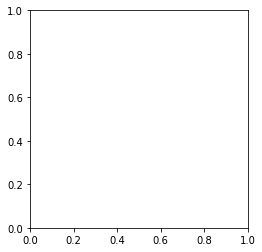

In [4]:
plt.imshow(a[0][1],  cmap='gray')

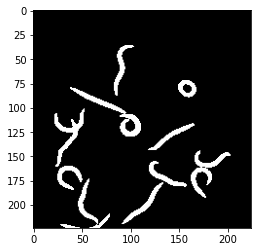

In [70]:
plt.imshow(data[1][1][0],  cmap='gray')


In [5]:



transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
])

target_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
])

data = BBBC010Dataset("BBBC010", transform=transform, target_transform=target_transform)


data_train, data_test = torch.utils.data.random_split(
    data, [60, 40], generator=torch.Generator().manual_seed(0))

data_loader_train = torch.utils.data.DataLoader(data_train,
                                          batch_size=16,
                                          shuffle=True)



data_loader_test = torch.utils.data.DataLoader(data_test,
                                          batch_size=16,
                                          shuffle=False)

dataset_sizes = {"train": len(data_train), "val": len(data_test)}
data_loaders = {"train": data_loader_train, "val": data_loader_test}

In [6]:

# model = torch.load("checkpoints/VOC_segmentation_deeplabv3_mobilenet_v3_large.pt")
# model = torch.load("checkpoints/unet_unewighted.pt")
model = models.unet_model.UNet(2,2)


In [72]:
model

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [6]:
def add_dropout(model, block, prob, omitted_blocks=[]):

    for name, p in block.named_children():
        if any(map(lambda x: isinstance(p, x), omitted_blocks)):
            continue
        if isinstance(p, torch.nn.Module) or isinstance(p, torch.nn.Sequential):
            add_dropout(model, p, prob, omitted_blocks)

        if isinstance(p, torch.nn.ReLU):
            setattr(block, name, torch.nn.Sequential(torch.nn.ReLU(), torch.nn.Dropout2d(p=prob)))
            # return model
add_dropout(model, model, 0.05)

model.classifier[0].project[2] = torch.nn.ReLU()
# model.classifier[3]=torch.nn.ReLU()
# model.aux_classifier[2]=torch.nn.ReLU()

In [8]:
model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [7]:
# model.classifier[0].project[2] = torch.nn.ReLU()
model.classifier[0].project[3] = torch.nn.Dropout(p=0)

model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Sequential(
            (0): ReLU()
            (1): Dropout2d(p=0.05, inplace=False)
          )
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvN

In [7]:
from tqdm import tqdm
import torchmetrics  

def compute_segmentation_loss_weights(dataset: dict, num_classes):
    counts = np.zeros(num_classes, dtype="int64")
    for _, _, _, gt in dataset:
        for i in range(num_classes):
            counts[i] += (gt == i).sum()
    all_count = counts.sum()
    weights = [np.sqrt(all_count / count) if count > 0 else 1.0 for count in counts]
    return weights


def train_model(model, num_epochs, optimizer, criterion, data_loaders, device):
    softmax = nn.Softmax(dim=1)
    model.to(device)
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}', flush=True)
        print('-' * 10, flush=True)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            running_entropy = 0.0
            running_maxes = 0.0
            numel = 0
            count = 0
            progress_bar = tqdm(data_loaders[phase])
            for inputs, labels in progress_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                numel += labels.numel()
                optimizer.zero_grad()
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                probs = softmax(outputs).detach()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_maxes += torch.sum(torch.max(probs, dim=1)[0])

                epoch_loss = loss.item()
                iou = torchmetrics.functional.jaccard_index(preds, labels).item()
                dice = torchmetrics.functional.dice_score(preds, labels).item()
                epoch_acc = running_corrects.double() / numel
                # epoch_entropy = running_entropy / count
                epoch_avg_max = running_maxes / count
                progress_str = f'{phase} Loss: {epoch_loss:.2f} Acc: {epoch_acc:.2f} IOU: {iou:.2f} DICE: {dice:.2f} Avg. max. prob: {epoch_avg_max:.2f}'
                progress_bar.set_description(progress_str)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
train_progress = train_model(
    model, 50, optimizer, criterion, data_loaders, device)

Epoch 1/50
----------


  0%|          | 0/4 [00:00<?, ?it/s]


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of size: : [16, 1, 1, 224, 224]

In [6]:
from utils.temperature_scaling import ModelWithTemperature
scaled_model = ModelWithTemperature(model)
scaled_model.temperature = torch.nn.Parameter(torch.tensor(1.458))
# scaled_model.set_temperature(data_loader, device)

In [6]:
from tqdm import tqdm
import torchmetrics  
from typing import OrderedDict
import torch.nn.functional as F




def run_validation(model, data_loader, test_progress: utils.metrics.Progress, device, mc_dropout_iters=0):
    softmax = nn.Softmax(dim=1)
    progress_bar = tqdm(data_loader)
    count = 0
    running_corrects = 0
    model = model.to(device)
    softmax = torch.nn.Softmax(dim=1)
    for inputs, labels in progress_bar:
        # labels = (labels * 255).squeeze().to(torch.uint8)
        # labels[labels == 255] = 21
        inputs = inputs.to(device)
        count += labels.numel()
        model.eval()
        with torch.no_grad():
            logits = model(inputs)
        if isinstance(logits, OrderedDict):
            logits = logits["out"]    
        logits = logits.cpu()
        probs = softmax(logits)
        max_probs, preds = torch.max(probs, 1)
        # print(iou(preds, labels))
        # return
        running_corrects += np.count_nonzero(preds == labels.squeeze(1))
        # print(torchmetrics.functional.iou(
        # preds, labels, ignore_index=21, num_classes=22))
        if mc_dropout_iters > 0:
            mc_means, mc_vars = utils.mc_dropout.mc_dropout(
                model, inputs, logits.shape[1:], T=mc_dropout_iters)
            # batch_nll = - utils.mc_dropout.compute_log_likelihood(
            #     mc_means, torch.nn.functional.one_hot(labels, num_classes=mc_means.shape[-1]), torch.sqrt(mc_vars))
            batch_nll = torch.tensor([0])
            mc_predictions = mc_means.argmax(axis=1)
            test_progress.dropout_outputs.append(mc_means.numpy())
            test_progress.dropout_predictions = np.append(
                test_progress.dropout_predictions, mc_predictions)
            test_progress.dropout_variances = np.append(
                test_progress.dropout_variances, mc_vars)

        test_progress.update(preds, labels, probs, logits)
        progress_bar.set_description(
            f"Avg. acc.: {100*running_corrects/count:.2f}")

    test_progress.predictions = np.concatenate(test_progress.predictions)
    test_progress.logits = np.concatenate(test_progress.logits)
    test_progress.probs = np.concatenate(test_progress.probs)
    if mc_dropout_iters > 0:
        test_progress.dropout_outputs = np.concatenate(
            test_progress.dropout_outputs)
    return test_progress


progress = run_validation(
    model, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=0)

# progress_scaled = run_validation(
#     scaled_model, data_loader, utils.metrics.Progress(), device, mc_dropout_iters=0)    

Avg. acc.: 67.87: 100%|██████████| 91/91 [01:10<00:00,  1.29it/s]


In [15]:
progress.predictions.size, progress.labels.size 

(1526805504, 72705024)

In [23]:


print(torchmetrics.functional.jaccard_index(preds[:64], labels[:64]))


# print(torchmetrics.functional.jaccard_index(preds_mcd, labels))


tensor(0.4148)


In [10]:
def iou(preds, labels):
    preds = F.one_hot(preds)
    labels = F.one_hot(labels)
    intersection = (preds & labels).sum((0,1,2))
    union = (preds | labels).sum((0,1,2))
    iou = (intersection) / (union)
    print(iou)
    
    return iou.nanmean()

preds = torch.Tensor(progress.predictions).to(torch.long)

# preds_mcd = torch.Tensor(progress.dropout_predictions.reshape(progress.predictions.shape)).to(torch.uint8)


labels = torch.Tensor(progress.labels.reshape(progress.predictions.shape)).to(torch.long)

print(iou(preds, labels))
# torchmetrics.functional.jaccard_index(preds[:32], labels[:32],absent_score=torch.nan, reduction="none").nanmean(), torchmetrics.functional.jaccard_index(preds[32:64], labels[32:64], absent_score=torch.nan, reduction="none").nanmean(), torchmetrics.functional.jaccard_index(preds[:64], labels[:64], absent_score=torch.nan, reduction="none").nanmean()


tensor([7.1614e-01, 1.2371e-01, 0.0000e+00, 4.7320e-03, 7.1914e-05, 1.1589e-04,
        8.4656e-02, 1.5148e-01, 1.6395e-01, 0.0000e+00, 3.6731e-04, 3.7785e-03,
        6.9166e-02, 4.2592e-03, 1.6238e-01, 3.3113e-01, 5.5864e-03, 9.4461e-02,
        0.0000e+00, 1.5427e-01, 7.5260e-05])
tensor(0.0986)


In [52]:
(0.5701 + 0.4562) / 2

0.51315

In [7]:
preds.shape, labels.shape

NameError: name 'preds' is not defined

NameError: name 'labels' is not defined

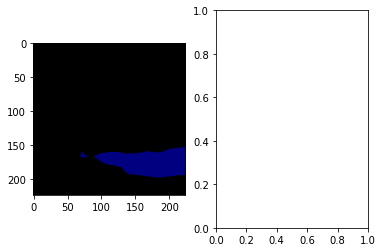

In [9]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(decode_segmap(progress.predictions[2]))
axs[1].imshow(decode_segmap(labels[2]))

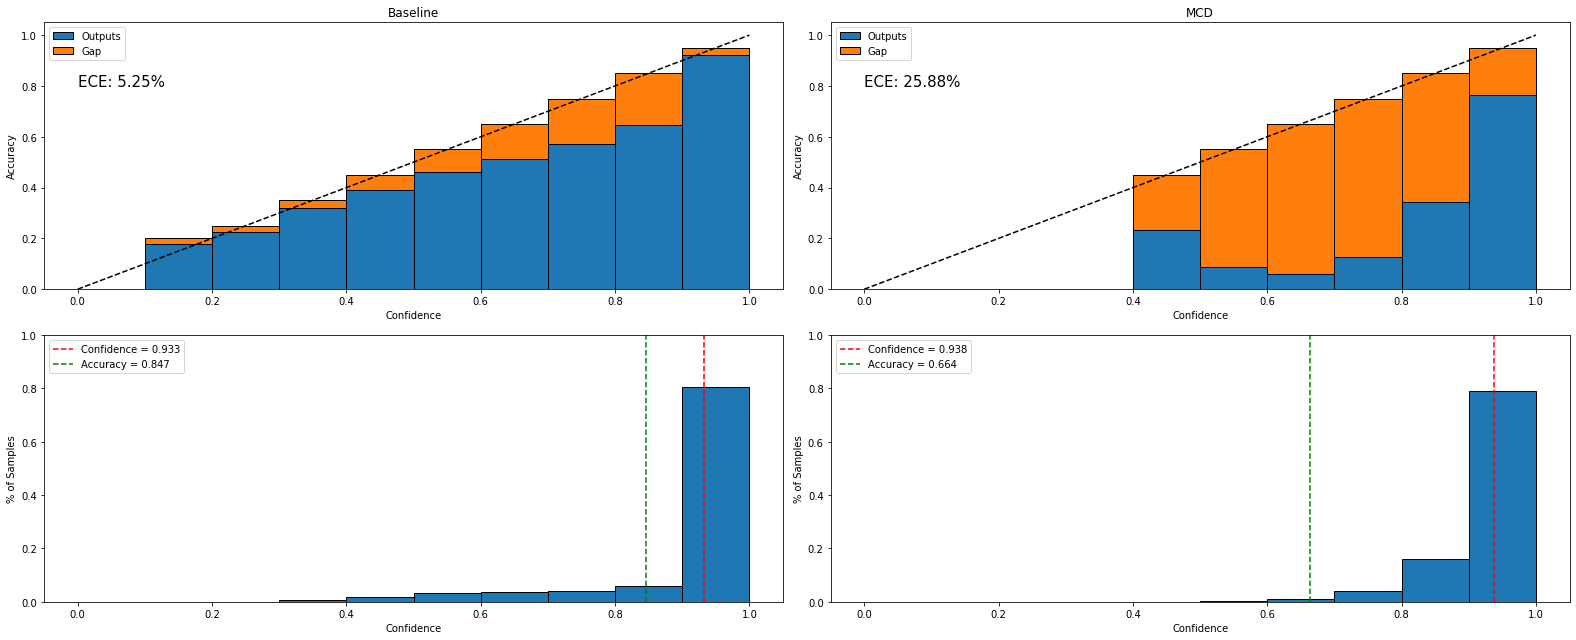

In [ ]:
# nll = nn.CrossEntropyLoss()(torch.tensor(progress.logits), torch.tensor(
#     progress.labels, dtype=torch.long)).item()
# print(
#     f"Accuracy: {(progress.predictions==progress.labels).sum()*100/len(progress.labels):.2f}%, "
#     f"NLL: {nll:4f}"
# )

# # mc_logits = progress.dropout_logits.mean(axis=0)
# dropout_max_probs = progress.dropout_outputs.max(axis=-1)

# utils.visualisations.samples_removed_vs_acc([
#     ("Max prob", np.argsort(progress.max_probs)),
#     ("Dropout max probs", np.argsort(dropout_max_probs))],
#     progress.labels,
#     progress.predictions,
#     progress.dropout_predictions)

dropout_max_probs = progress.dropout_outputs.max(axis=1).ravel()

utils.visualisations.calibration_graph([
        ("Baseline", progress.max_probs, np.argsort(progress.max_probs), progress.predictions.ravel()),
        ("MCD", dropout_max_probs, np.argsort(dropout_max_probs), progress.dropout_outputs.argmax(axis=1).ravel()),
        # ("Temp scaling", progress_scaled.max_probs, np.argsort(progress_scaled.max_probs), progress_scaled.predictions.ravel()),



    ],
    progress.labels,
    )

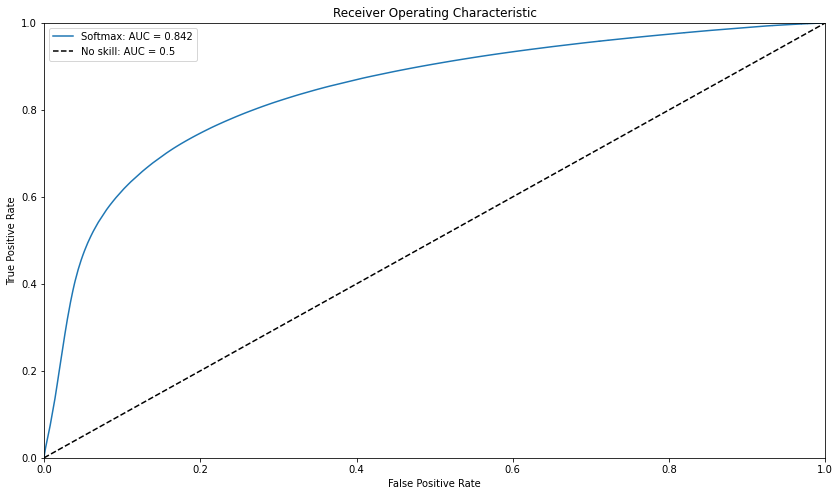

In [12]:
curves = []

correct = progress.predictions.ravel() == progress.labels.ravel()
fpr, tpr, _ = metrics.roc_curve(correct, progress.max_probs)
roc_auc = metrics.auc(fpr, tpr)

prec, recall, _ = metrics.precision_recall_curve(correct, progress.max_probs)
aupr = metrics.auc(recall, prec)
curves.append({
    "fpr": fpr,
    "tpr": tpr,
    "auroc": roc_auc,
    "prec": prec,
    "recall": recall,
    "aupr": aupr,
    "label": "Softmax"
})

# correct = progress.dropout_predictions == progress.labels
# dropout_max_probs = progress.dropout_outputs.max(axis=-1)
# fpr, tpr, _ = metrics.roc_curve(correct, dropout_max_probs)
# roc_auc = metrics.auc(fpr, tpr)

# prec, recall, _ = metrics.precision_recall_curve(correct, dropout_max_probs)
# aupr = metrics.auc(recall, prec)

# curves.append({
#     "fpr": fpr,
#     "tpr": tpr,
#     "auroc": roc_auc,
#     "prec": prec,
#     "recall": recall,
#     "aupr": aupr,
#     "label": "MC Dropout"
# })


plt.figure(figsize=(14, 8))
plt.title('Receiver Operating Characteristic')
for curve in curves:
    plt.plot(curve["fpr"], curve["tpr"],
             label=f"{curve['label']}: AUC = {curve['auroc']:.3f}")
plt.plot([0, 1], [0, 1], 'k--', label=f"No skill: AUC = 0.5")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

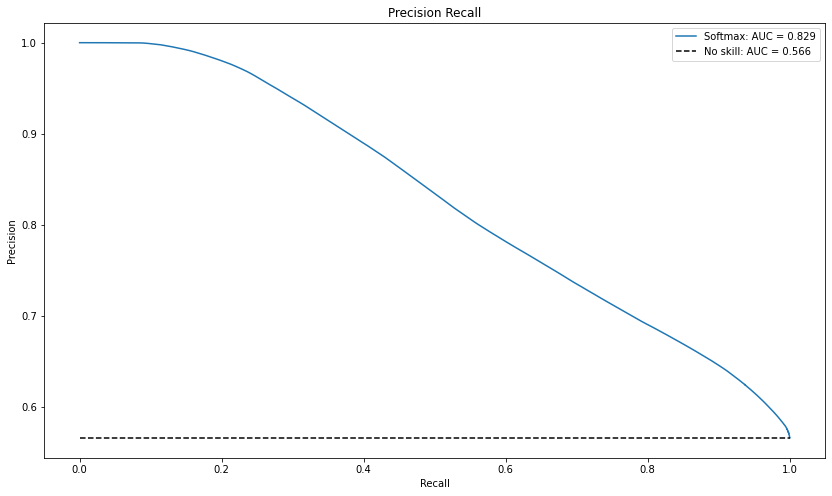

In [10]:
no_skill = correct.sum() / len(correct)
plt.figure(figsize=(14, 8))
plt.title('Precision Recall')
for curve in curves:
    plt.plot(curve["recall"], curve["prec"],
             label=f"{curve['label']}: AUC = {curve['aupr']:.3f}")
# axis labels
plt.plot([0, 1], [no_skill, no_skill], color="k",
         linestyle='--', label=f'No skill: AUC = {no_skill:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()